# HuBMAP - BASELINE


![](https://storage.googleapis.com/kaggle-competitions/kaggle/22990/logos/header.png)

<a id="1"></a>
<h2 style='background:#EAA6D1; border:0; color:white'><center>BASELINE CODE<center><h2>

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile
import json
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F
from torchvision import models
import random
from torch.utils.data import DataLoader
from torch import optim
from torch.optim import lr_scheduler
from torch.autograd import Variable


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import collections
import time

# Configuration

In [2]:
# Device & Path
DEVICE = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BASE_PATH = "../DATA"

TEST_PATH = os.path.join(BASE_PATH, "test")

print(os.listdir(BASE_PATH))

TRAIN_CSV = os.path.join(BASE_PATH, "train", "df_train.csv")

TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

WIDTH = 512
HEIGHT = 512

resize_factor = False # 0.5

BATCH_SIZE = 2
NUM_EPOCHS = 1

# Normalize to resnet mean and std if True.
NORMALIZE = False
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# No changes tried with the optimizer yet.
MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# cell type specific thresholds
cell_type_dict = {'blood_vessel': 1, 'glomerulus': 2, 'unsure': 3}
mask_threshold_dict = {1: 0.40, 2: 0.80, 3:  0.80}
min_score_dict = {1: 0.40, 2: 0.80, 3: 0.80}

# Use a StepLR scheduler if True. 
USE_SCHEDULER = False
TEST_SIZE=0.20
BOX_DETECTIONS_PER_IMG = 500

['tile_meta.csv', 'maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth', 'wsi_meta.csv', 'test', 'train', 'polygons.jsonl', 'sample_submission.csv']


In [3]:
torch.backends.mps.is_available()

True

## Hyperparameter Setting

In [4]:
# CFG = {
#     'IMG_SIZE':224,
#     'EPOCHS':50,
#     'LEARNING_RATE':3e-4,
#     'BATCH_SIZE':64,
#     'SEED':41
# }

# Utilites

In [5]:
# ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    maskimg = np.zeros((HEIGHT, WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg


def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []
    use_labels = []
    for i, mask in enumerate(pred["masks"]):
        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)
            use_labels.append(label)

    return use_masks,use_labels


In [6]:
# maP IoU

In [7]:
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.6, 6.5, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = mask_threshold_dict[labels.sort_values().index[-1]]
        masks_p,labels_p=get_filtered_masks(result)
        pred_masks = combine_masks(masks_p, mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)


### Transformations
Just Horizontal and Vertical Flip for now.

Normalization to Resnet's mean and std can be performed using the parameter `NORMALIZE` in the top cell.

The first 3 transformations come from [this](https://www.kaggle.com/abhishek/maskrcnn-utils) utils package by Abishek, `VerticalFlip` is my adaption of HorizontalFlip, and `Normalize` is of my own.

In [8]:
# These are slight redefinitions of torch.transformation classes
# The difference is that they handle the target and the mask
# Copied from Abishek, added new ones
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)
    

## Dataset & Dataloader

In [9]:

cell_type_dict = {'blood_vessel': 1, 'glomerulus': 2, 'unsure': 3}
class HuBMAPDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
            print("image size used:", self.height, self.width)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby(["image_id"])[['annotations','category_id']].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['image_id'],
                    'image_path': os.path.join(self.image_dir, row['image_id'] + '.tif'),
                    'annotations': list(row["annotations"]),
                    'category_name': list(row["category_id"])
                    }
            
    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        labels = []
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))        
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            boxes.append(self.get_box(a_mask))
        labels = info["category_name"]        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target#,img_path

    def __len__(self):
        return len(self.image_info)

## Fixed RandomSeed

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

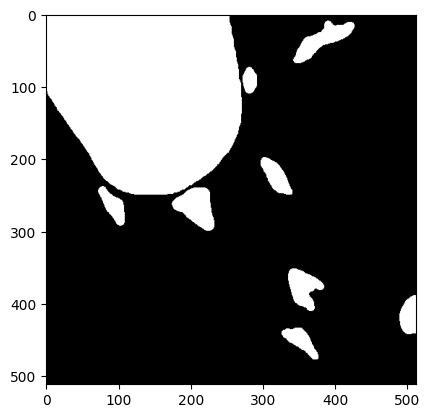

In [11]:
#json file load
data = []

with open(os.path.join(BASE_PATH, 'polygons.jsonl'), 'r') as file:
    for line in file:
        data.append(json.loads(line))

# 한 이미지에 대한 정보만 추출
image_data = data[0]

image_id = image_data['id']
annotations = image_data['annotations']

# 이미지 읽어서 크기 얻기
image = Image.open(os.path.join(TRAIN_PATH, f'{image_id}.tif')) 
width, height = image.size

# 이미지와 같은 크기의 빈 마스크 생성
mask = np.zeros((height, width), dtype=np.uint8)

# 각 객체에 대한 정보 추출
for annotation in annotations:
    mask_type = annotation['type']
    coordinates = annotation['coordinates']

    # 각 폴리곤 좌표를 numpy 배열로 변환
    for polygon in coordinates:
        contour = np.array(polygon, dtype=np.int32)

        # OpenCV의 fillPoly 함수를 사용하여 마스크에 폴리곤 그리기
        cv2.fillPoly(mask, [contour], color=(255))

plt.imshow(mask, cmap='gray')
plt.show()


In [12]:
df_ = pd.read_csv(TRAIN_CSV)
df_.head(3)
df_images = df_.groupby(["image_id", "category_name"]).agg({'annotations': 'count'}).sort_values("annotations", ascending=False).reset_index()
# Use the quantiles of amoount of annotations to stratify
df_images_train, df_images_val = train_test_split(df_images, stratify=df_images['category_name'], 
                                                  test_size=TEST_SIZE,
                                                  random_state=42)
df_train = df_[df_['image_id'].isin(df_images_train['image_id'])]
df_val = df_[df_['image_id'].isin(df_images_val['image_id'])]

In [13]:
df_

,Unnamed: 0,image_id,category_id,category_name,annotations,bbox,area,iscrowd
0,0,0006ff2aa7cd,2,glomerulus,2 253 513 254 1025 254 1537 254 2049 254 2561 ...,"(0, 0, 271, 250)",56426,0
1,1,0006ff2aa7cd,1,blood_vessel,37657 3 38167 7 38678 8 39190 10 39701 11 4021...,"(272, 73, 20, 37)",570,0
2,2,0006ff2aa7cd,1,blood_vessel,121934 3 122444 7 122955 9 123466 10 123978 11...,"(72, 238, 37, 55)",1027,0
3,3,0006ff2aa7cd,1,blood_vessel,199677 4 200187 6 200697 8 201208 9 201719 10 ...,"(489, 389, 23, 54)",996,0
4,4,0006ff2aa7cd,1,blood_vessel,222553 10 223053 5 223063 13 223564 25 224073 ...,"(326, 434, 51, 44)",1055,0
...,...,...,...,...,...,...,...,...
17513,17513,ffd3d193c71e,1,blood_vessel,146108 3 146618 6 147128 8 147639 12 148149 15...,"(173, 285, 23, 24)",396,0
17514,17514,ffd3d193c71e,1,blood_vessel,16940 3 17451 5 17962 7 18473 8 18984 9 19495 ...,"(28, 33, 21, 60)",736,0
17515,17515,ffd3d193c71e,1,blood_vessel,235285 8 235796 11 236307 13 236819 14 237331 ...,"(273, 459, 24, 22)",384,0
17516,17516,ffd3d193c71e,1,blood_vessel,138217 4 138728 6 139239 8 139751 8 140262 10 ...,"(476, 269, 25, 120)",1789,0


### Dataset & Dataloader

In [14]:
ds_train = HuBMAPDataset(TRAIN_PATH, df_train, resize=resize_factor, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                      num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

ds_val = HuBMAPDataset(TRAIN_PATH, df_val, resize=resize_factor, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                    num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

## Set-up Model

In [15]:
cache_dir = os.path.expanduser("~/.cache/torch/hub/checkpoints/")
os.makedirs(cache_dir, exist_ok=True)
!cp /Users/admin/Documents/GitHub/HuBMAP-Hacking_the_Human_Vasculature/DATA/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth $cache_dir


In [16]:
def get_model(num_classes, model_chkpt=None):    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN,
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)
    if model_chkpt:
        model.load_state_dict(torch.load(model_chkpt, map_location=DEVICE))
    return model
# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS
model = get_model(len(cell_type_dict))
model.to(DEVICE)

# TODO: try removing this for
for param in model.parameters():
    param.requires_grad = True
    
model.train();

## Training Loop

In [17]:
from torch.nn.parallel import DataParallel
# DataParallel로 모델 감싸기
model = DataParallel(model)

# 장치 설정

model.to(DEVICE)


DataParallel(
  (module): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (b

In [18]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1


In [19]:
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_mask_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
    
        # Predict
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum += loss_dict['loss_classifier'].item()
        
        if batch_idx % 500 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}.")
                        
    if USE_SCHEDULER:
        lr_scheduler.step()

    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches

    # Validation
    val_loss_accum = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    elapsed = time.time() - time_start

    validation_mask_losses.append(val_loss_mask)

    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d}/{NUM_EPOCHS:2d}]"
    print(f"{prefix} -- train mask loss: {train_loss_mask:7.3f}, classes loss {train_loss_classifier:7.3f}")
    print(f"{prefix} -- val mask loss  : {val_loss_mask:7.3f}, classes loss {val_loss_classifier:7.3f}")
    print(f"{prefix} -- train loss: {train_loss:7.3f}. val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
    print("---------------------------------------------------------------------------------------------")

Starting epoch 1 of 1


In [9]:
all_files_list = os.listdir(TRAIN_PATH)

# 이미지 파일명과 마스크 파일명을 저장할 리스트 생성
image_file_list = []
mask_file_list = []
image_file_path_list = []
# 모든 파일에 대해서 반복
for file in all_files_list:
    image_files_path = os.path.join(TRAIN_PATH, file)

    # 이미지 파일인 경우
    if file.endswith('.tif'):
        # 이미지 파일명을 리스트에 추가
        image_file_list.append(file)
        
        # 마스크 파일명 생성
        mask_file = file.replace('.tif', '')
        
        # 마스크 파일명을 리스트에 추가
        mask_file_list.append(mask_file)

        # 이미지 파일 경로를 리스트에 추가
        image_file_path_list.append(image_files_path)

# 데이터 프레임 생성
df = pd.DataFrame({'image': image_file_list, 'mask': mask_file_list, 'path': image_file_path_list})

# 데이터 프레임 출력
print(df.head())
print(df.shape)

              image          mask                            path
0  0b7772cced70.tif  0b7772cced70  ../DATA/train/0b7772cced70.tif
1  a212a174533b.tif  a212a174533b  ../DATA/train/a212a174533b.tif
2  bb14110c0ad9.tif  bb14110c0ad9  ../DATA/train/bb14110c0ad9.tif
3  9877c0dfede4.tif  9877c0dfede4  ../DATA/train/9877c0dfede4.tif
4  9227f6ede08f.tif  9227f6ede08f  ../DATA/train/9227f6ede08f.tif
(7033, 3)


In [81]:
df

,image,mask,path
0,0b7772cced70.tif,0b7772cced70,../DATA/train/0b7772cced70.tif
1,a212a174533b.tif,a212a174533b,../DATA/train/a212a174533b.tif
2,bb14110c0ad9.tif,bb14110c0ad9,../DATA/train/bb14110c0ad9.tif
3,9877c0dfede4.tif,9877c0dfede4,../DATA/train/9877c0dfede4.tif
4,9227f6ede08f.tif,9227f6ede08f,../DATA/train/9227f6ede08f.tif
...,...,...,...
7028,7f34441a1f79.tif,7f34441a1f79,../DATA/train/7f34441a1f79.tif
7029,3f23a41f4bc4.tif,3f23a41f4bc4,../DATA/train/3f23a41f4bc4.tif
7030,d20e93312427.tif,d20e93312427,../DATA/train/d20e93312427.tif
7031,f2683290d169.tif,f2683290d169,../DATA/train/f2683290d169.tif


In [78]:
df

,image,mask,path
0,0b7772cced70.tif,0b7772cced70,../DATA/train/0b7772cced70.tif
1,a212a174533b.tif,a212a174533b,../DATA/train/a212a174533b.tif
2,bb14110c0ad9.tif,bb14110c0ad9,../DATA/train/bb14110c0ad9.tif
3,9877c0dfede4.tif,9877c0dfede4,../DATA/train/9877c0dfede4.tif
4,9227f6ede08f.tif,9227f6ede08f,../DATA/train/9227f6ede08f.tif
...,...,...,...
7028,7f34441a1f79.tif,7f34441a1f79,../DATA/train/7f34441a1f79.tif
7029,3f23a41f4bc4.tif,3f23a41f4bc4,../DATA/train/3f23a41f4bc4.tif
7030,d20e93312427.tif,d20e93312427,../DATA/train/d20e93312427.tif
7031,f2683290d169.tif,f2683290d169,../DATA/train/f2683290d169.tif


In [48]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, dilations):
        super(ASPP, self).__init__()
        self.aspp_blocks = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 1),
            nn.Conv2d(in_channels, out_channels, 3, padding=dilations[0], dilation=dilations[0]),
            nn.Conv2d(in_channels, out_channels, 3, padding=dilations[1], dilation=dilations[1]),
            nn.Conv2d(in_channels, out_channels, 3, padding=dilations[2], dilation=dilations[2])
        ])
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(in_channels, out_channels, 1))        
    def forward(self, x):
        x_aspp = torch.cat([aspp(x) for aspp in self.aspp_blocks], dim=1)
        x_gap = self.global_avg_pool(x)
        x_gap = F.interpolate(x_gap, size=x_aspp.size()[2:], mode='bilinear', align_corners=True)
        return torch.cat([x_aspp, x_gap], dim=1)


class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=4, dilations=[1, 6, 12]):
        super(DeepLabV3Plus, self).__init__()
        # Use resnet101 in torchvision as backbone
        resnet101 = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet101.children())[:-2])

        self.aspp = ASPP(2048, 256, dilations)  # Atrous Spatial Pyramid Pooling module
        self.conv1 = nn.Conv2d(256, 48, 1, bias=False)  # Low-level features
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.last_conv = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),  # Changed input channels from 304 to 1072
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, num_classes, kernel_size=1, stride=1)
        )
        
    def forward(self, x):
        input_size = x.size()[2:]
        low_level_feat = self.backbone[0:5](x)
        output_feature = self.backbone[5:](low_level_feat)

        output_feature = self.aspp(output_feature)
        output_feature = F.interpolate(output_feature, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)

        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)
        low_level_feat = self.dropout(low_level_feat)

        x = torch.cat((output_feature, low_level_feat), dim=1)
        x = self.last_conv(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        return x



In [67]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes=4, dilations=[1, 6, 12], pretrained=True):
        super(DeepLabV3Plus, self).__init__()
        # Use resnet101 in torchvision as backbone
        resnet101 = models.resnet101(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet101.children())[:-2])

        # Freeze the backbone layers
        if pretrained:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.aspp = ASPP(2048, 256, dilations)  # Atrous Spatial Pyramid Pooling module
        self.conv1 = nn.Conv2d(256, 48, 1, bias=False)  # Low-level features
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.last_conv = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, num_classes, kernel_size=1, stride=1)
        )
        
    def forward(self, x):
        input_size = x.size()[2:]
        low_level_feat = self.backbone[0:5](x)
        output_feature = self.backbone[5:](low_level_feat)

        output_feature = self.aspp(output_feature)
        output_feature = F.interpolate(output_feature, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)

        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)
        low_level_feat = self.dropout(low_level_feat)

        x = torch.cat((output_feature, low_level_feat), dim=1)
        x = self.last_conv(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        return x


In [68]:
from pycocotools import mask as mask_utils

class MAPIOUEvaluator:
    def __init__(self, dataset):
        self.dataset = dataset
        self.reset()

    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if out is None:
                self.scores.append(0)
            else:
                image_id = inp['image_id']
                pred_mask = out.squeeze().detach().cpu().numpy() > 0.5  # apply threshold
                enc_pred = mask_utils.encode(np.asfortranarray(pred_mask.astype("uint8")))

                # Get the ground truth mask
                gt_mask = inp['mask']
                enc_gt = mask_utils.encode(np.asfortranarray(gt_mask.astype("uint8")))

                # Compute the IoU
                iou = mask_utils.iou([enc_pred], [enc_gt], [0])[0, 0]
                self.scores.append(iou)

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}


In [79]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
train_transform = A.Compose([
                            A.Resize(64, 64),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(64, 64),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
class PolygonDataset(Dataset):
    def __init__(self, annotations_df, json_path, transform=None):
        super(PolygonDataset, self).__init__()
        
        self.img_files = annotations_df['image']
        self.img_paths = annotations_df['path']
        self.transform = transform

        # Load all data from the json file
        self.annotations = {}
        with open(json_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                # Match image id and its annotations
                self.annotations[data['id']] = data['annotations']

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = img.resize((128, 128))  

        # Image id is the filename without extension
        img_id = os.path.splitext(self.img_files[idx])[0]

        # Find the corresponding annotations using image id
        annotations = self.annotations.get(img_id, [])

        # Create mask
        mask = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
        for annotation in annotations:
            for polygon in annotation['coordinates']:
                contour = np.array(polygon, dtype=np.int32)
                cv2.fillPoly(mask, [contour], color=(255))

        # If a transform function is given, apply it on the image and the mask
        if self.transform:
            transformed = self.transform(image=np.array(img), mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        return {'image': img, 'mask': mask, 'image_id': img_id}


# define parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 50

# 데이터를 훈련 세트와 검증 세트로 분할
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# 인덱스 초기화
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# create datasets

# Create datasets
train_dataset = PolygonDataset(train_data, json_path=os.path.join(BASE_PATH, 'polygons.jsonl'), transform=train_transform)
val_dataset = PolygonDataset(val_data, json_path=os.path.join(BASE_PATH, 'polygons.jsonl'), transform=test_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# create model
model = DeepLabV3Plus(num_classes=4, dilations=[1, 6, 12, 18]).to(DEVICE)  # initialize model

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # optimizer


In [80]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

KeyError: 0

In [ ]:
def dice_score(output, target, eps=1e-7):
    output = output.view(-1).detach().cpu().numpy()
    target = target.view(-1).detach().cpu().numpy()
    intersection = (output * target).sum()
    return (2. * intersection) / (output.sum() + target.sum() + eps)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_dice_score = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, masks)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_dice_score += dice_score(outputs, masks) * images.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_dice_score = running_dice_score / len(train_loader)

    print('Train Epoch: {}, Loss: {:.4f}, Dice Score: {:.4f}'.format(epoch, epoch_loss, epoch_dice_score))

    # validate the model
    model.eval()
    running_loss = 0.0
    running_dice_score = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
            running_dice_score += dice_score(outputs, masks) * images.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_dice_score = running_dice_score / len(val_loader)

    print('Validation Epoch: {}, Loss: {:.4f}, Dice Score: {:.4f}'.format(epoch, epoch_loss, epoch_dice_score))

    # print statistics or save the model
    # your code here


RuntimeError: Given groups=1, weight of size [256, 304, 3, 3], expected input[16, 1328, 16, 16] to have 304 channels, but got 1328 channels instead

## Inference

In [ ]:
test = pd.read_csv(TEST_CSV)

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

## Submission

In [ ]:
submit = pd.read_csv(SAMPLE_PATH)

In [ ]:
submit['label'] = preds

In [ ]:
from datetime import datetime, timedelta, timezone
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(DATA_PATH, 'results', train_serial)

# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    
RESULT_PATH = os.path.join(RECORDER_DIR, 'submission.csv')

In [ ]:
submit.to_csv(RESULT_PATH, index=False)